In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from datetime import date
from matplotlib.animation import FuncAnimation
from requests_ntlm import HttpNtlmAuth
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pycountry_convert as pc
import os
import re
import shutil
import time
import datetime

%matplotlib notebook

In [2]:
def find_csv(directory = "."):
    file_candidates = []
    today = datetime.datetime.today().strftime("%m-%d-%Y")
    for root, dirs, files in os.walk(directory):
        for file in files:
            filename = os.path.join(root, file)
            if filename.endswith(".csv"):
                path = os.path.abspath(filename)
                mtime = os.path.getmtime(filename)
                mod_timestamp = datetime.datetime.fromtimestamp(mtime)
                mod_timestamp = mod_timestamp.strftime("%m-%d-%Y")
                if mod_timestamp == today:
                    file_candidates.append((path, mtime))

    return file_candidates

In [3]:
def sort_files(file_list):
    if len(file_list) == 1:
        return file_list[0][0]
    file_list = sorted(file_list, key=lambda x: x[1], reverse=True)
    return file_list[0][0]    

In [4]:
def get_ecdc_data():
    """
    This function will search the local directory for today's dataset.
    If not found, it will request the data from the ECDC dashboard and
    store a local copy.
    
    If no data is found and no valid HTTP request is given, the local
    direcory will be searched for the most data file.
    """
    try:
        today = datetime.date.today()
        filename = str(today) + '_ECDC_data.csv'
        if os.path.exists(os.path.join(os.getcwd(), filename)):
            return pd.read_csv(filename)
        r = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv',
                    auth=HttpNtlmAuth(':',':'))
        data = r.text.replace('\r', '')
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(data)
    except:
        print(f"Unable to access ECDC resource, please check online to ensure"+
              f" the data is still available")
        print(f"\nSearching for the most recent dataset in {os.getcwd()}")
        file_candidates = find_csv(directory = os.getcwd())
        filename = sort_files(file_candidates)
        print(f"\nThe file selected for analysis is: {filename}")

        pass

    return pd.read_csv(filename)
            
get_ecdc_data()

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14-days
0,01/02/2021,2021-04,267,16,Afghanistan,AF,AFG,38041757.0,Asia,2.58
1,25/01/2021,2021-03,713,43,Afghanistan,AF,AFG,38041757.0,Asia,3.34
2,18/01/2021,2021-02,557,45,Afghanistan,AF,AFG,38041757.0,Asia,3.24
3,11/01/2021,2021-01,675,71,Afghanistan,AF,AFG,38041757.0,Asia,4.15
4,04/01/2021,2020-53,902,60,Afghanistan,AF,AFG,38041757.0,Asia,7.61
...,...,...,...,...,...,...,...,...,...,...
10428,20/04/2020,2020-16,11,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.11
10429,13/04/2020,2020-15,5,2,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05
10430,06/04/2020,2020-14,2,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05
10431,30/03/2020,2020-13,5,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05


In [5]:
def format_columns(dataframe):
    df = dataframe
    cols = [c for c in df.columns]
    pattern = re.compile(r"[A-Z]")
    for i, c in enumerate(cols):
        match = re.search(pattern, c)
        while match != None:
            span = match.span()
            first, last = span[0], span[1]
            c = c[:first] + "_" + c[first:last].lower() + c[last:]
            match = re.search(pattern, c)
        cols[i] = c
    df.columns = cols
    return df


In [6]:
def format_dates(dataframe):
    df = dataframe
    dates = list(set(df.date_rep))
    formatted = [datetime.datetime.strptime(date, '%d/%m/%Y').date()
                 for date in dates]
    formatted = [datetime.datetime.strftime(date, '%Y-%m-%d')
                 for date in formatted]
    map_dict = dict(zip(dates, formatted))
    df.date_rep = df.date_rep.map(map_dict)
    return df


In [7]:
def add_dates(data_dataframe):
    """
    The ECDC .csv file contains dates for all entries listed
    but does not contain the dates prior to when countries reported
    their first confirmed case.
    
    This function takes returns an dataframe with indexes that include
    the original date. This will be merged with the data using the 
    'unmelt()' function.
    """
    
#     origin = date(year, month, day) # earliest recorded date in WHO files
#     last = data_dataframe.iloc[-1, :]["DateRep"]
    dates = list(set(data_dataframe.date_rep))
    dates = [datetime.datetime.strptime(date, "%Y-%m-%d").date() 
             for date in dates]
    dates = sorted(dates)
    first, last = dates[0], dates[-1]
    delta = last-first # days since earliest report
    date_list = pd.date_range(first, periods=delta.days)
    df = pd.DataFrame(date_list)
    df.columns = ["date"]
    df.set_index("date", inplace=True)
    
    return df


In [8]:
def unmelt(data_dataframe, dates_dataframe, column):
    """
    This function reorganizes the .csv to have all 
    countries contained as columns within a single
    dataframe.
    
    """
    data = data_dataframe
    dates = dates_dataframe
    for country in set(data.countries_and_territories):
        sub = data[data.countries_and_territories==country][["date_rep", column]].set_index("date_rep")
        sub.columns=[country]
        dates = pd.merge(dates, sub, left_index=True, right_index=True, how="outer").fillna(0)

    return dates

In [9]:

def add_world_data(data_dataframe):
    df = data_dataframe
    totals = []
    for row in df.index:
        totals.append(df.loc[row, :].sum(axis=0))
    df2 = pd.Series(totals, index=df.index)
    df["World"] = df2
    return df



def get_top1(data_dataframe):
    df = data_dataframe
    last_day = df.index[-1]
    percentile = df.loc[last_day, "World"] * 0.01
    top1_countries = df.loc[last_day, :] > percentile
    df = df[top1_countries.index[top1_countries]].drop("World", axis=1)

    return df


In [11]:
data = get_ecdc_data()
data = format_columns(data)
data = format_dates(data)
dates = add_dates(data)
cases = unmelt(data, dates, "cases_weekly").cumsum()
cases = add_world_data(cases)
deaths = unmelt(data, dates, "deaths_weekly").cumsum()
deaths = add_world_data(deaths)


In [25]:
deaths

,Bulgaria,Bahamas,Malaysia,Chad,Jamaica,Cambodia,New_Caledonia,Bangladesh,Greece,Croatia,...,Venezuela,Malawi,Serbia,Honduras,Saudi_Arabia,Kosovo,Micronesia_(Federated_States_of),Panama,South_Korea,World
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-28,8820.0,175.0,678.0,116.0,338.0,0.0,0.0,8023.0,5646.0,4859.0,...,1148.0,518.0,3886.0,3462.0,6352.0,1456.0,0.0,5098.0,1360.0,2138359.0
2021-01-29,8820.0,175.0,678.0,116.0,338.0,0.0,0.0,8023.0,5646.0,4859.0,...,1148.0,518.0,3886.0,3462.0,6352.0,1456.0,0.0,5098.0,1360.0,2138359.0
2021-01-30,8820.0,175.0,678.0,116.0,338.0,0.0,0.0,8023.0,5646.0,4859.0,...,1148.0,518.0,3886.0,3462.0,6352.0,1456.0,0.0,5098.0,1360.0,2138359.0
2021-01-31,8820.0,175.0,678.0,116.0,338.0,0.0,0.0,8023.0,5646.0,4859.0,...,1148.0,518.0,3886.0,3462.0,6352.0,1456.0,0.0,5098.0,1360.0,2138359.0


In [12]:
def country_to_color(country):
    continents = ["NA", "SA", "EU", "AS", "AF", "OC", "Other"]
#     colors = ["#6D4B8D", "#D27268", "#ACA537", "#4E9E60", "#C68B54", "#407985", "#A1A196"]
    colors = ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50']
    c_dict = dict(zip(continents, colors))
    cont_colors = []
    try:
        code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent = pc.country_alpha2_to_continent_code(code)
        return c_dict[continent]
    except:
        return c_dict["Other"]

In [13]:
top1_cases = get_top1(cases)

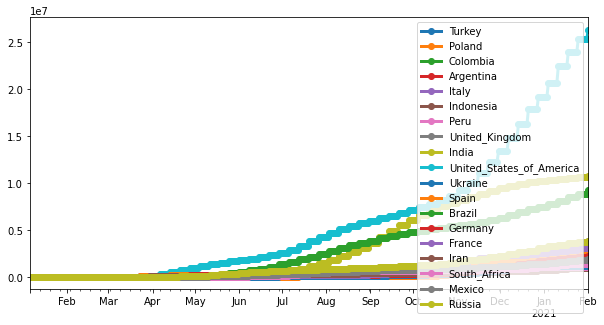

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
top1_cases.plot.line(linewidth=3, marker="o", ax=ax)

<IPython.core.display.Javascript object>


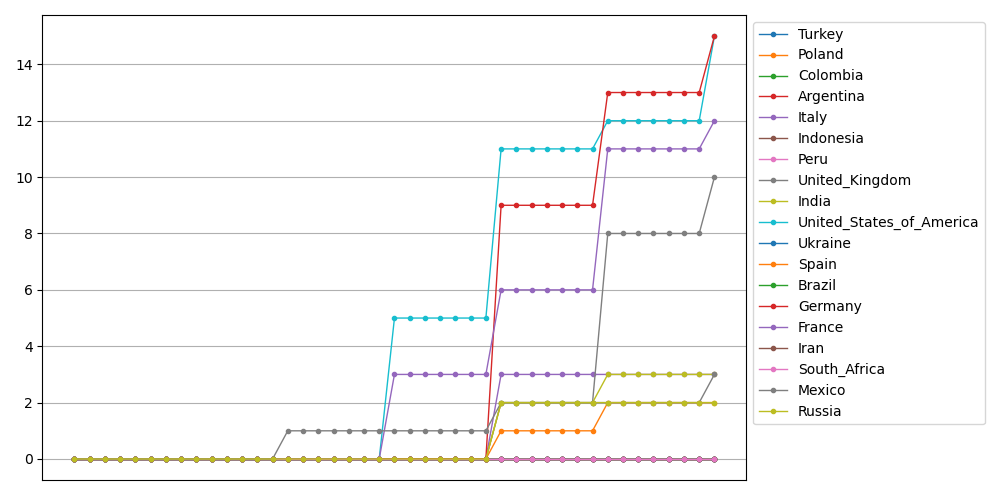

In [15]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 5))

i = 0

def animate(i):
    data = top1_cases.iloc[:i+1, :]
    x = data.index
    y = data.loc[:, :].values
    display(data)
    ax.clear()
    ax.plot(x, y, linewidth=1, marker="o", markersize=3)
    ax.legend(labels=[c for c in data.columns],
               bbox_to_anchor=[1,1])
#     ax.tick_params(axis="y", colors="k", labelsize=12)
    ax.grid(which="major", axis="y", linestyle="-")
    ax.set_xticks([])
    plt.tight_layout()

# animate(25)
ani = FuncAnimation(plt.gcf(), animate, frames=len(top1_cases), interval=10, blit=True)

<IPython.core.display.Javascript object>


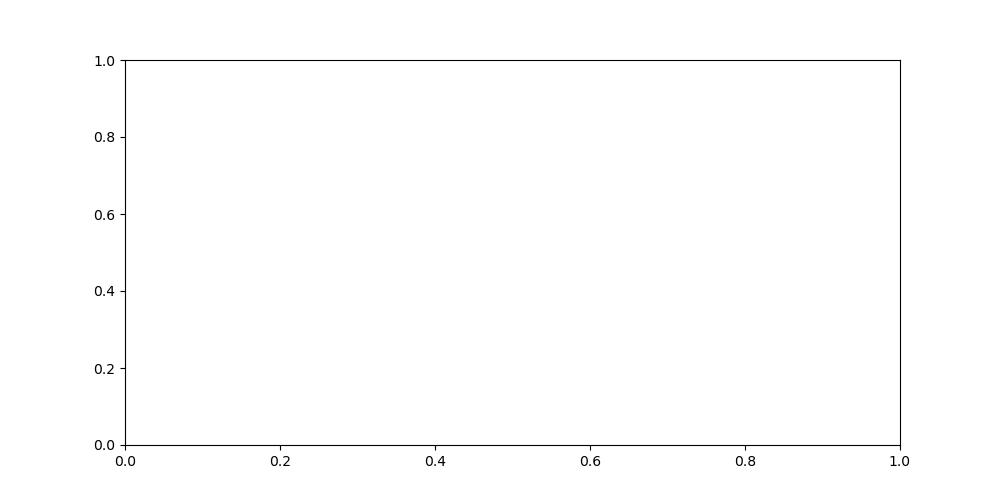

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

def draw_barchart(date):
    
    sub_df = top1_cases[top1_cases.index==date].T.sort_values(by=date)
#     display(sub_df)
    ax.clear()
    ax.barh(sub_df.index, sub_df[date], color=[country_to_color(x) for x in sub_df.index])
    dx = sub_df[date].max() / 200 
    for i, (value, name) in enumerate(zip(sub_df[date], sub_df.index)):
        ax.text(value-dx,    i,    name,     size=10, weight=600, ha="right", va="center")
        ax.text(value+dx,    i,    f"{value:,.0f}",    size=12, ha="left", va="center")
    ax.text(1.0, 0.4, date.strftime("%m/%d"), transform=ax.transAxes, size=24)
    ax.grid(which="major", axis="x")
    ax.xaxis.set_ticks_position('top')
    ax.set_axisbelow(True)
    ax.set_yticks([])
    plt.box(False)
    
    
origin = date(2019, 12, 31) # earliest recorded date in WHO files
today = date.today()
delta = today-origin # days since earliest report
date_list = pd.date_range(origin, periods=delta.days)
date_list[0]
# draw_barchart(date_list[0])

ani = FuncAnimation(fig, draw_barchart, interval=250, frames=date_list)

In [19]:
def extrapolate(dataframe):
    df = dataframe
    cols = [c for c in df.columns]
    res = {}
    for col in cols:
        df2 = df[col]
        new_data = []
        for i, val in enumerate(df2):
            if i == len(df2)-1:
                break
            start_val = df2[i]
            end_val = df2[i+1]
#             print(i, start_val, end_val)
#             array = np.arange(start_val, end_val+0.1, ((end_val-start_val)/24), dtype=int)
            array = np.linspace(start_val, end_val, 5)
            new_data.extend(array)
        res[col] = pd.Series(new_data)
    return pd.DataFrame(res)
        

test = extrapolate(top1_cases)

In [20]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

Traceback (most recent call last):
  File "C:\Users\graha\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\graha\AppData\Roaming\Python\Python38\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


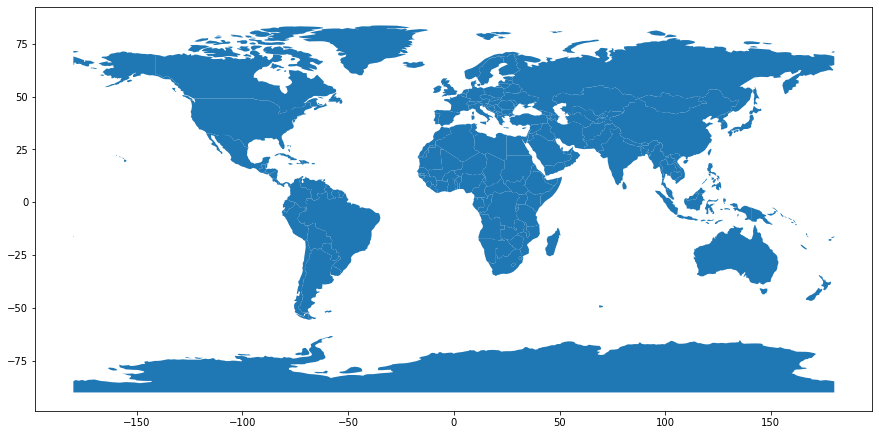

In [21]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(15,12))
world.plot(ax=ax)

In [22]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [23]:
countries = [c.replace("_", " ") for c in cases.columns]
print(f"{len(countries)} exist in 'countries' list")
overlapping = world[world.name.isin(countries)]
print(f"{overlapping.shape[0]} countries overlap with 'World' dataframe")
w_dict = world.set_index("name").T.to_dict()
country_geo = [w_dict[c]["geometry"] for c in countries if c in w_dict]

216 exist in 'countries' list
155 countries overlap with 'World' dataframe


In [24]:
date = (date_list[0])
cases.columns = [c.replace("_", " ") for c in cases.columns]
sub_df = cases[cases.index==date].T.sort_values(by=date)
sub_world = world.set_index('name')
sub_world = pd.merge(left=sub_world, right=sub_df, left_on=sub_world.index, right_on=sub_df.index, how="inner")

KeyError: Timestamp('2019-12-31 00:00:00', freq='D')

In [ ]:
sub_world.plot(column=date)

In [ ]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(10,8))
cases.columns = [c.replace("_", " ") for c in cases.columns]

def animate(date):
    sub_df = cases[cases.index==date].T
    sub_world = world.set_index('name')
    sub_world = pd.merge(left=sub_world, right=sub_df, left_on=sub_world.index,
                         right_on=sub_df.index, how="left")
    sub_world[date] = sub_world[date] / max(sub_world[date])
    ax.clear()
    display(sub_world)
    sub_world.plot(column=date, ax=ax, cmap='OrRd', missing_kwds={'color': 'lightgrey'})
    ax.set_yticks([])
    ax.set_xticks([])
    plt.box(False)
    
# animate(date_list[-25])
ani = FuncAnimation(plt.gcf(), animate, interval=250, frames=date_list)